## Import libraries and load data

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

yolosac = pd.read_csv('yolosac3.csv')
# yolosac3 has multiple listings of the same business
yolosac.drop_duplicates(subset=['gmap_id'], inplace=True)
#yolosac.set_index('gmap_id', inplace=True)
yolosac.drop(yolosac.columns[0], axis=1, inplace=True)

reviews = pd.read_json('data/ys-reviews-with-categories.json', orient='records')


## All Categories

In [2]:
categories = print(yolosac['category'].explode().value_counts())

category
restaurant    3554
auto          2064
retail        1757
beauty        1267
recreation    1201
health         737
grocery        449
education      345
Name: count, dtype: int64


Our model will use the reviews dataset from `ys-reviews-with-categories.zip` to predict a business's success score. Success depends on number of reviews and the rating score.
All the variables we will use are categorical. We intend to extract vectors with the most relevant words from each review.

In [3]:
yolosac.head()

,name,gmap_id,category,avg_rating,num_of_reviews
0,Aurora Massage,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty,4.2,56
1,Orient Massage,0x809adee9ac6f1bd7:0xe2e56d16919b9b8d,beauty,3.6,15
2,Valley Gaming & Billiards Home,0x809add6b2d273da5:0x4610dea4cb4aa5df,retail,4.1,18
3,Dan's Mission Towing,0x809ad4111dd01501:0xf8adf3a057108e2a,auto,3.3,6
4,Caballo Bronco Barber Styling,0x809ad73dbbfe5ef1:0x45f57e4e50d4c232,beauty,4.0,28


In [4]:
reviews.head()

,text,rating,gmap_id,category
0,Helped me alot. If it was for her suggesting m...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
1,Always leave feeling refreshed...polite and re...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
2,Professional massage place. The ladies know w...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
3,This place was pleasing to me. Very nice staff...,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty
4,Tough lady loves great pressure massage. Woohoo.,5.0,0x809ad993cd15cc69:0x38291ec9a11f59ed,beauty


Text(0.5, 1.0, 'Frequency of businesses for each category')

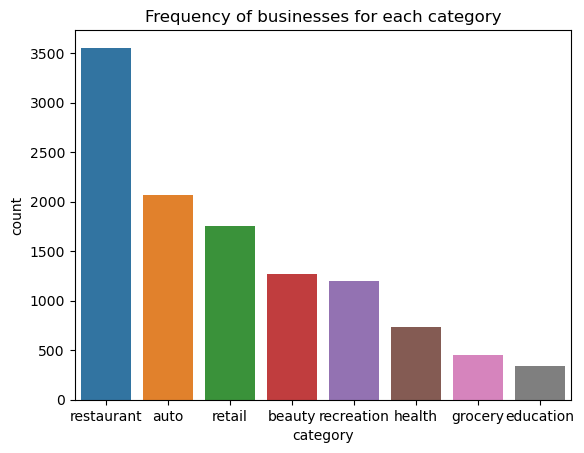

In [6]:
sns.countplot(data=yolosac, x='category', order=yolosac['category'].value_counts().index)
plt.title('Frequency of businesses for each category')

Text(0.5, 1.0, 'Frequency of reviews for business categories')

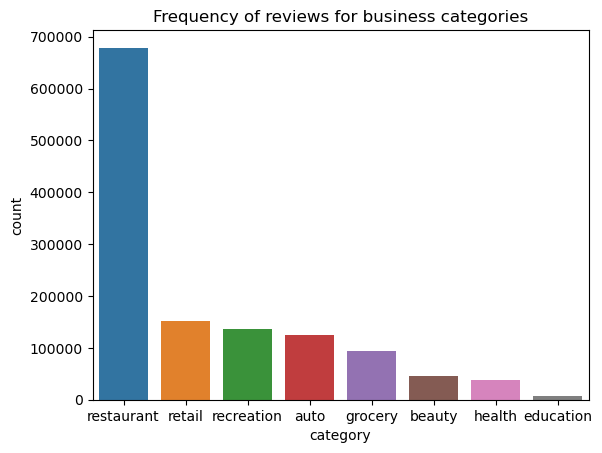

In [7]:
sns.countplot(data=reviews, x='category', order=reviews['category'].value_counts().index)
plt.title('Frequency of reviews for business categories')

Observations:
- About half of all reviews are from restaurants

In [8]:
review_freq_norm = reviews['category'].value_counts() / yolosac['category'].value_counts()
print(review_freq_norm.sort_values(ascending=False))

category
grocery       208.944321
restaurant    190.984524
recreation    114.218984
retail         85.940239
auto           60.371609
health         51.240163
beauty         36.284136
education      19.979710
Name: count, dtype: float64


Observations:
- Grocery businesses get the most reviews on average
- Restaurants get the second most reviews on average
- Educational institutions get the least reviews on average

Questions:
- Grocery business includes big-box stores like Walmart and Target. Do these chains contribute to over-inflated review counts?

Question: What is the distribution of businesses with 1-2, 2-3, 3-4, 4-5 star ratings? Does it vary across business categories?

<Axes: xlabel='avg_rating', ylabel='Count'>

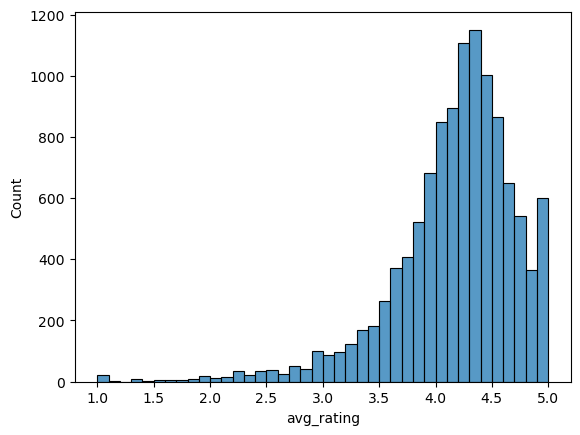

In [52]:
sns.histplot(data=yolosac, x='avg_rating', binwidth=0.1)

Observations:
- Business ratings are highly skewed left

Question:
- Do we need to reduce the number of highy rated businesses in training data?
- What is the cutoff for being a successful business?

In [10]:
# business count for each rating bucket (1-2, 2-3, 3-4, 4-5)
# Lower limit of 0.9 accounts for businesses with 1-star rating
print(pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5]).value_counts())

# 4-5 star businesses vs. all other businesses
print(pd.cut(yolosac['avg_rating'], [0.9, 4 ,5]).value_counts())


avg_rating
(4.0, 5.0]    8025
(3.0, 4.0]    2903
(2.0, 3.0]     372
(0.9, 2.0]      74
Name: count, dtype: int64
avg_rating
(4.0, 5.0]    8025
(0.9, 4.0]    3349
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of 4-5 star businesses')

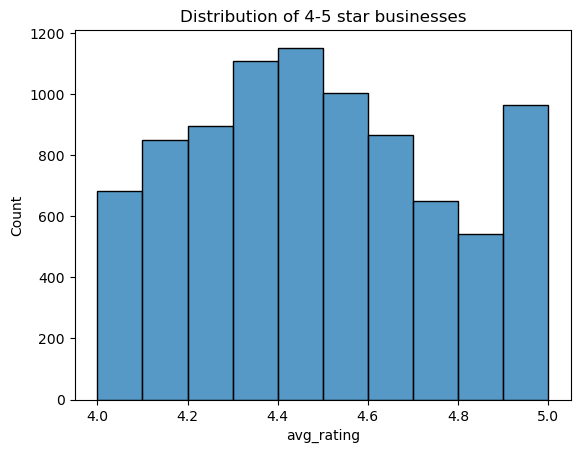

In [11]:
sns.histplot(data=yolosac[(yolosac['avg_rating'] >= 4)], x='avg_rating', bins=10)
plt.title('Distribution of 4-5 star businesses')

4-5 star businesses are roughly normally distributed, except at the right end. This is probably because the last bin includes 5-star businesses that may only have a few reviews.

In [12]:
split_on_ratings = pd.cut(yolosac['avg_rating'], [0.9, 2, 3, 4 ,5])
split_on_ratings.head

<bound method NDFrame.head of 0        (4.0, 5.0]
1        (3.0, 4.0]
2        (4.0, 5.0]
3        (3.0, 4.0]
4        (3.0, 4.0]
            ...    
11425    (4.0, 5.0]
11426    (4.0, 5.0]
11427    (4.0, 5.0]
11428    (4.0, 5.0]
11429    (4.0, 5.0]
Name: avg_rating, Length: 11374, dtype: category
Categories (4, interval[float64, right]): [(0.9, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0]]>

In [13]:
print(reviews.dropna().shape)
print(reviews.shape)

(1268124, 4)
(1275985, 4)


## Restaurants

### Restaurant businesses

In [28]:
restaurants = yolosac[yolosac['category'] == 'restaurant']

In [29]:
# restaurant count for each rating bucket (1-2, 2-3, 3-4, 4-5)
# Lower limit of 0.9 accounts for restaurants with 1-star rating
print(pd.cut(restaurants['avg_rating'], [0.9, 2, 3, 4 ,5]).value_counts())

# > 4 star restaurants vs. <= 4 star restaurants
print(pd.cut(restaurants['avg_rating'], [0.9, 4 ,5]).value_counts())

avg_rating
(4.0, 5.0]    2483
(3.0, 4.0]    1017
(2.0, 3.0]      45
(0.9, 2.0]       9
Name: count, dtype: int64
avg_rating
(4.0, 5.0]    2483
(0.9, 4.0]    1071
Name: count, dtype: int64


Observations:
- More than half of all restaurant businesses have an average rating above 4 stars
- Very few have below a 3 star average rating. Perhaps low-rated restaurants go out of business quickly.

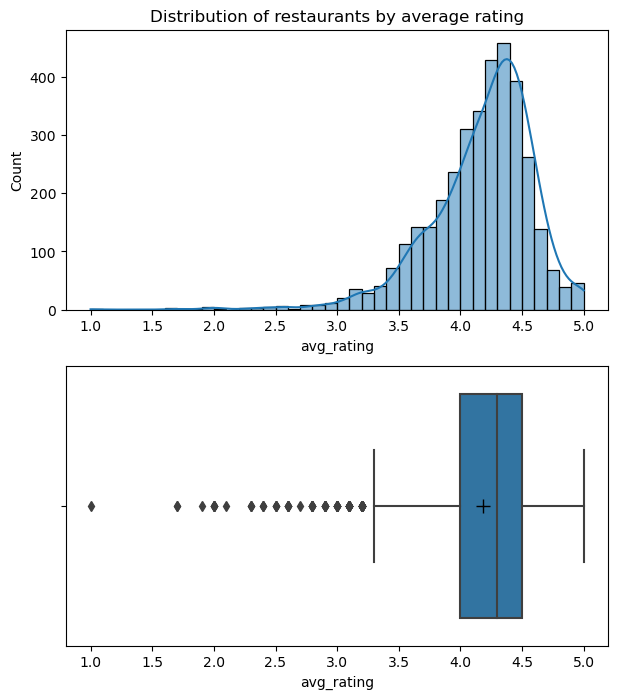

In [51]:
fig, axes = plt.subplots(2, figsize=(7,8))
axes[0].set_title('Distribution of restaurants by average rating')
# Historgram
sns.histplot(data=restaurants, x='avg_rating', binwidth=0.1, ax=axes[0], kde=True)
# Box Plot with mean represented as '+'
sns.boxplot(data=restaurants, x='avg_rating', ax=axes[1], showmeans=True, meanprops={'marker':'+', 'markeredgecolor':'black', 'markersize':10})

plt.show()

Observations:
- Restaurant business ratings are highly skewed left
- Mean review rating is 4.2 stars
- Median review rating is 4.4 stars
- IQR of review ratings is between 4 and 4.5 stars
- There are outliers between 1 and 3.3 stars

In [54]:
restaurant_reviews = reviews[reviews['category'] == 'restaurant']

In [57]:
# review count for each rating bucket (1, 2, 3, 4 ,5)
print(restaurant_reviews['rating'].value_counts())

# 5 star reviews vs. all other reviews
print(pd.cut(restaurant_reviews['rating'], [0.9, 4 ,5]).value_counts())

rating
5.0    391725
4.0    131390
1.0     62586
3.0     60430
2.0     32531
Name: count, dtype: int64
rating
(4.0, 5.0]    391725
(0.9, 4.0]    286937
Name: count, dtype: int64


Observations:
- More than half of restaurant reviews are 5 stars.
- 2 star reviews are least common, followed by 3 star reviews

Questions:
- What type of sentiment is associated wth 5-star reviews? Do people tend to give 5 stars when they are satisfied or impressed?
- What are the indicators of a 4-star or lower review?

Text(0.5, 1.0, 'Distribution of restaurant reviews')

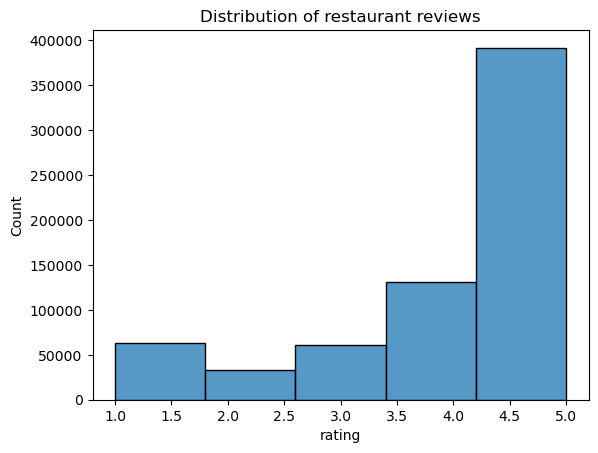

In [58]:
sns.histplot(data=restaurant_reviews, x='rating', bins=5)
plt.title('Distribution of restaurant reviews')

Observations:
- Restaurant review ratings are skewed left